<a href="https://colab.research.google.com/github/Zeynepsuleb/DSA210/blob/main/DSA%20210%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Asset Return Analysis & Classification

This notebook explores the historical performance of key financial assets (KYD Eurobond, BIST 100, Gold) and compares them against a 1-month KYD deposit index. We also attempt to classify daily returns as positive or negative using machine learning.

**Goals**:
- Understand asset behavior via exploratory data analysis (EDA)
- Conduct hypothesis testing (e.g., whether the portfolio outperforms the deposit index)
- Apply a binary classification model to predict the direction of next-day returns


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
from google.colab import files
uploaded = files.upload()  # Bu satır çalışınca Colab sana dosya seçtirecek

import pandas as pd
import io

filename = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[filename]), sheet_name="Sheet1")



Saving data set on prices of assets.xlsx to data set on prices of assets.xlsx


### 1) Feature Engineering
- Computed daily percentage returns for each asset
- Created an equal-weighted portfolio
- Added deposit index returns as a benchmark
- Created a binary target: 1 if portfolio return > 0, else 0


In [ ]:
# Calculate daily returns
returns = df[["KYD Eurobond Index", "BIST 100 Index", "Gold Ounce/USD Rate"]].pct_change().dropna()

# Create equal-weight portfolio
returns["Portfolio"] = returns.mean(axis=1)

# Add benchmark return
returns["Deposit"] = df["KYD Deposit Index (1 Month)"].pct_change().dropna()

# Create binary classification target
returns["Target"] = (returns["Portfolio"] > 0).astype(int)
returns.head()


<ipython-input-8-3ba38db34300>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df[["KYD Eurobond Index", "BIST 100 Index", "Gold Ounce/USD Rate"]].pct_change().dropna()
<ipython-input-8-3ba38db34300>:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns["Deposit"] = df["KYD Deposit Index (1 Month)"].pct_change().dropna()


,KYD Eurobond Index,BIST 100 Index,Gold Ounce/USD Rate,Portfolio,Deposit,Target
1,0.005290,0.001398,0.016415,0.007701,0.008625,1
2,-0.003221,0.013801,-0.006052,0.001509,-0.004171,1
3,-0.001820,0.003525,-0.018470,-0.005588,-0.004571,0
4,0.002599,-0.014332,0.018469,0.002245,0.007287,1
5,0.009505,-0.005612,0.027227,0.010373,0.010600,1




This table is a part of the dataset prepared for portfolio analysis and classification modeling. Each row represents one day’s financial asset returns and shows the performance of both the portfolio and the deposit index on that specific day.

* The **KYD Eurobond Index**, **BIST 100 Index**, and **Gold Ounce/USD Rate** columns contain the daily percentage returns of the corresponding assets.
* The **Portfolio** column indicates the daily return of an equally weighted portfolio composed of these three assets.
* The **Deposit** column represents the return of the KYD 1-Month Deposit Index for the same day.
* The **Target** column is the classification label created for the model; it is assigned `1` if the portfolio return is positive, and `0` otherwise.

This structure provides a clean and meaningful data foundation for both evaluating portfolio performance and predicting the direction of daily returns. The model is trained on this structure to estimate whether the portfolio’s return will be positive under specific market conditions.



According to the data in the fifth row, the KYD Eurobond return is 0.96%, the BIST 100 return is –0.56%, and the Gold return is 2.72%. The equal-weighted average of these three assets results in a daily portfolio return of 1.03%. On the same day, the deposit index return is 1.06%. Although the deposit yield is slightly higher than the portfolio’s return, the portfolio still shows a positive return. Therefore, the `Target` value is labeled as 1. This means that the model classifies that day as a “profitable day.”


---



### 2) Exploratory Data Analysis (EDA)
- Price trends of the main assets are visualized
- The portfolio's return distribution is plotted with a KDE curve to examine normality



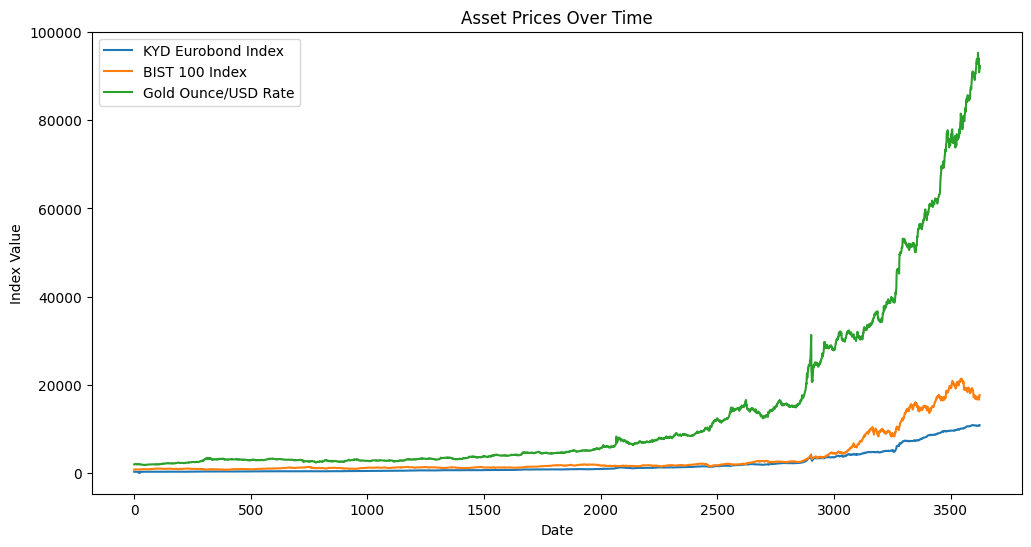

In [ ]:
# Plot time series of asset prices
df[["KYD Eurobond Index", "BIST 100 Index", "Gold Ounce/USD Rate"]].plot(figsize=(12, 6), title="Asset Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.show()


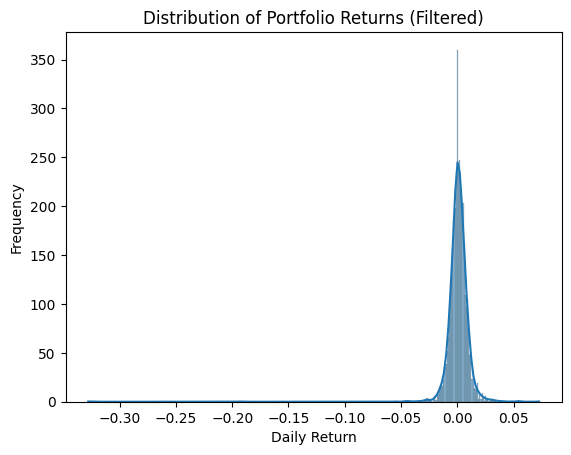

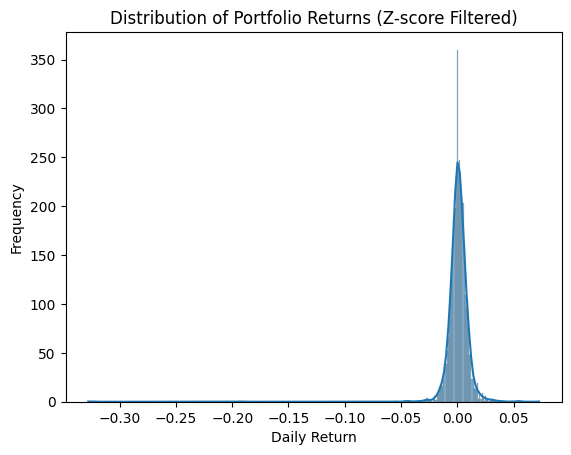

In [ ]:
# Plot distribution of portfolio returns
from scipy.stats import zscore

# Method 1: Exclude returns above 10% (to remove extreme outliers)
filtered_returns = returns[returns["Portfolio"] < 0.1]

sns.histplot(filtered_returns["Portfolio"], kde=True)
plt.title("Distribution of Portfolio Returns (Filtered)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

# Method 2: Remove outliers using z-score
returns_filtered = returns[(np.abs(zscore(returns["Portfolio"])) < 3)]

sns.histplot(returns_filtered["Portfolio"], kde=True)
plt.title("Distribution of Portfolio Returns (Z-score Filtered)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


**General** **Evaluation**:

* In terms of long-term return, gold appears to be the most profitable asset.

* Eurobonds offer steady and lower-risk growth over time.

* BIST 100 may provide high returns at times but also carries higher volatility, making it relatively riskier.


The filtered histogram of portfolio returns reveals a sharp peak centered around **zero**, indicating that most daily returns are clustered very close to the mean. The distribution appears leptokurtic, suggesting low variance on most days but with the presence of rare, extreme return values. The symmetry of the distribution implies that the portfolio does not exhibit significant bias toward gain or loss days, though volatility spikes may still occur infrequently.


---



### 3) Hypothesis Testing

Null Hypothesis (H₀):
There is no statistically significant difference between the mean daily return of the portfolio and the mean daily return of the deposit index.

Alternative Hypothesis (H₁):
The mean daily return of the portfolio is significantly greater than the mean daily return of the deposit index.
- If p < 0.05, we reject the null hypothesis.


In [ ]:
# Hypothesis: Portfolio returns > Deposit returns
t_stat, p_val = stats.ttest_rel(returns["Portfolio"], returns["Deposit"])
print("T-statistic:", t_stat)
print("P-value:", p_val)


T-statistic: 1.4119219285745739
P-value: 0.15805616531629268


* Since the p-value (0.158) is greater than the significance level of 0.05, we fail to reject the null hypothesis.

Therefore, there is not enough statistical evidence to conclude that the portfolio's mean daily return is significantly greater than that of the deposit index.


---



### 4) Machine Learning Classification
- Features: asset returns (KYD Eurobond, BIST 100, Gold) and Deposit
- Target: Binary outcome (1 if portfolio return > 0, otherwise 0)
- Model: Logistic Regression
- Metrics: Precision, recall, F1-score


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

#  Remove extreme outliers from the 'Portfolio' column using z-score
returns_filtered = returns[(np.abs(zscore(returns["Portfolio"])) < 3)]

#  Separate feature matrix (X) and target vector (y)
X = returns_filtered.drop(columns=["Target"])
y = returns_filtered["Target"]

# Standardize the features to improve model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

#  Create and train the logistic regression model
# class_weight='balanced' helps deal with class imbalance
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

#  Make predictions on the test set
y_pred = model.predict(X_test)

#  Print evaluation metrics: precision, recall, f1-score, confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       493
           1       1.00      0.96      0.98       629

    accuracy                           0.98      1122
   macro avg       0.97      0.98      0.98      1122
weighted avg       0.98      0.98      0.98      1122

Confusion Matrix:
 [[492   1]
 [ 25 604]]




###  Summary Interpretation:

* **Accuracy:** 98% → The model makes highly accurate predictions overall.
* **Class 0 (negative return):** 95% precision, 100% recall → Almost all negative return days were correctly identified.
* **Class 1 (positive return):** 100% precision, 96% recall → Positive return days were predicted with excellent accuracy.
* **Confusion Matrix:** Only 1 false positive and 25 false negatives → Very low error rate.

---

###  Conclusion:

The model distinguishes between profitable and loss-making days almost flawlessly, making it a highly reliable tool for investment return prediction.



---

### Hypothesis and Method Summary

This project investigates whether the daily return of a portfolio consisting of KYD Eurobond, BIST 100, and Gold can be predicted using historical data.
The hypotheses are:

* **H₀:** The portfolio's daily return cannot be predicted using lagged returns and financial indicators.
* **H₁:** The portfolio's daily return can be predicted using lagged returns and financial indicators.

A logistic regression model was trained with features like `Portfolio`, `Deposit`, `Lag_1`, and `Lag_2`.
With over **98% accuracy**, the model results strongly support **H₁**, confirming that the portfolio’s direction is predictable based on past data.

---